<a href="https://colab.research.google.com/github/Harithaweera/AI-player-Analysis/blob/main/Player_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [ ]:
# !pip uninstall -y numpy pmdarima
# !pip install numpy==1.26.4 pmdarima --no-cache-dir

In [ ]:
# !pip install cudf-cu12 cuml-cu12 dask-cuda librosa umap-learn pynndescent shap

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import re
from scipy.stats import zscore
import numpy as np
import os



In [ ]:
print(os.listdir("/content/drive/My Drive/DATA SET/"))

['player_performance_100_matches.xlsx', 'cleaned_player_performance.xlsx']


connecting to the drive, - change to mongo

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


data extraction

In [ ]:
# Path to your Excel file in Google Drive
file_path = '/content/drive/My Drive/DATA SET/player_performance_100_matches.xlsx'


def preprocess_data(data):
    for column in data.columns[1:]:  # Skipping 'Match Number' column
        avg = data[column].mean()  # Compute average
        std = data[column].std()  # Compute standard deviation

        # Method 1: Z-score method for outlier detection
        z_scores = np.abs(zscore(data[column]))
        print(z_scores)
        outliers = z_scores > 1.96  # Threshold: 2.5 standard deviations

        # Replace outliers with the average
        data.loc[outliers, column] = avg

    return data

# Apply preprocessing to each sheet
for sheet_name in df:
    print(f"Processing sheet: {sheet_name}")
    df[sheet_name] = preprocess_data(df[sheet_name])

# Save cleaned data (optional)
cleaned_file_path = "/content/drive/My Drive/DATA SET/cleaned_player_performance.xlsx"
with pd.ExcelWriter(cleaned_file_path) as writer:
    for sheet_name, sheet_data in df.items():
        sheet_data.to_excel(writer, sheet_name=sheet_name, index=False)

print("✅ Preprocessing complete! Cleaned data saved.")

# # Load the Excel file into a Pandas DataFrame
# player1_df = pd.read_excel(file_path, sheet_name='P1')
# player2_df = pd.read_excel(file_path, sheet_name='P2')
# player3_df = pd.read_excel(file_path, sheet_name='P3')
# player4_df = pd.read_excel(file_path, sheet_name='P4')
# # player5_df = pd.read_excel(file_path, sheet_name='P5')
# # player6_df = pd.read_excel(file_path, sheet_name='P6')
# # player7_df = pd.read_excel(file_path, sheet_name='P7')
# # player8_df = pd.read_excel(file_path, sheet_name='P8')
# # player9_df = pd.read_excel(file_path, sheet_name='P9')
# # player10_df = pd.read_excel(file_path, sheet_name='P10')

# # Display the first few rows
# player1_df.head()

Processing sheet: P1
0     0.060063
1     1.049327
2     0.347328
3     0.479258
4     0.173013
        ...   
95    0.978316
96    1.596819
97    0.002924
98    1.678274
99    1.853566
Name: Smash Accuracy (%), Length: 100, dtype: float64
0     0.247434
1     0.026379
2     0.506012
3     0.513529
4     1.745846
        ...   
95    0.467759
96    1.382182
97    0.121735
98    1.179160
99    0.553167
Name: Drop Shot Accuracy (%), Length: 100, dtype: float64
0     1.399361
1     0.093793
2     1.655453
3     1.292846
4     0.276303
        ...   
95    1.710666
96    0.704793
97    1.697958
98    0.600321
99    1.431250
Name: Defense Effectiveness (%), Length: 100, dtype: float64
0     0.591026
1     0.435479
2     1.150549
3     1.489481
4     1.541007
        ...   
95    1.622872
96    0.328425
97    0.722882
98    0.015167
99    1.060786
Name: Error Rate (%), Length: 100, dtype: float64
0     0.619590
1     1.447966
2     0.873798
3     1.712836
4     0.667347
        ...   
95    

loading the cleaned data


In [ ]:
file_path_cleaned = '/content/drive/My Drive/DATA SET/cleaned_player_performance.xlsx'

# Load the Excel file into a Pandas DataFrame
player1_df = pd.read_excel(file_path_cleaned, sheet_name='P1')
player2_df = pd.read_excel(file_path_cleaned, sheet_name='P2')
player3_df = pd.read_excel(file_path_cleaned, sheet_name='P3')
player4_df = pd.read_excel(file_path_cleaned, sheet_name='P4')
# player5_df = pd.read_excel(file_path_cleaned, sheet_name='P5')
# player6_df = pd.read_excel(file_path_cleaned, sheet_name='P6')
# player7_df = pd.read_excel(file_path_cleaned, sheet_name='P7')
# player8_df = pd.read_excel(file_path_cleaned, sheet_name='P8')
# player9_df = pd.read_excel(file_path_cleaned, sheet_name='P9')
# player10_df = pd.read_excel(file_path_cleaned, sheet_name='P10')

# Display the first few rows
player1_df.head()

,Match Number,Smash Accuracy (%),Drop Shot Accuracy (%),Defense Effectiveness (%),Error Rate (%),Speed (m/s)
0,1,72.057632,67.986274,63.405455,18.432988,4.142683
1,2,58.354914,64.923332,79.844454,17.528615,6.582137
2,3,75.605804,57.546508,97.037667,8.307188,5.904691
3,4,65.396173,57.442344,64.578134,23.656752,6.894651
4,5,73.452739,88.748321,81.853812,23.956337,4.086336


In [ ]:
player2_df.head()

,Match Number,Smash Accuracy (%),Drop Shot Accuracy (%),Defense Effectiveness (%),Error Rate (%),Speed (m/s)
0,1,76.193298,76.814388,83.816679,12.418826,5.736055
1,2,88.286817,88.197612,93.832819,19.391861,3.396750
2,3,71.657161,47.804292,74.099222,13.431482,3.207494
3,4,78.060515,80.373486,89.224455,17.902036,4.319963
4,5,81.759401,86.769051,68.441907,13.221446,6.532075


Data analysis

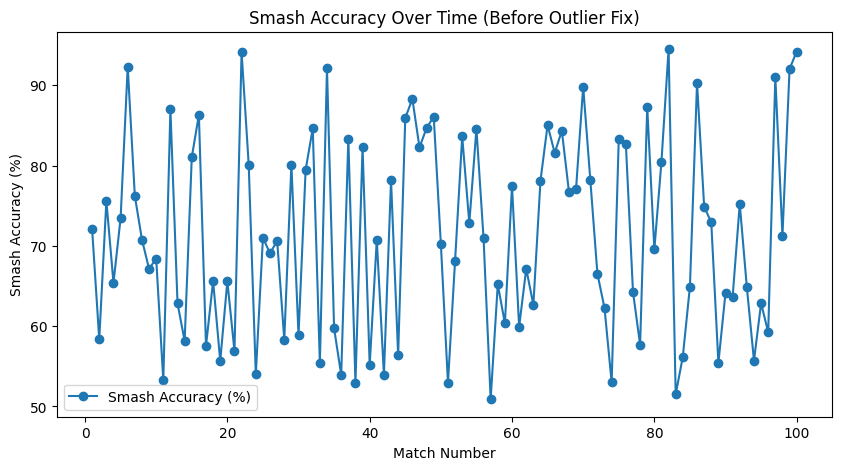

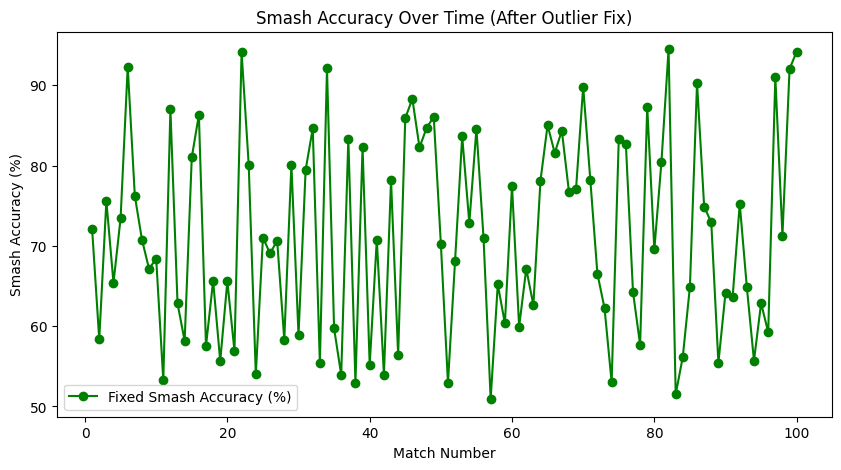


Original Data with Outliers:
    Match Number  Smash Accuracy (%)
0              1           72.057632
1              2           58.354914
2              3           75.605804
3              4           65.396173
4              5           73.452739
..           ...                 ...
95            96           59.232015
96            97           91.038992
97            98           71.279645
98            99           92.045098
99           100           94.210231

[100 rows x 2 columns]

Fixed Data (Outliers Replaced):
    Match Number  Smash Accuracy (%)
0              1           72.057632
1              2           58.354914
2              3           75.605804
3              4           65.396173
4              5           73.452739
..           ...                 ...
95            96           59.232015
96            97           91.038992
97            98           71.279645
98            99           92.045098
99           100           94.210231

[100 rows x 2 columns]


In [120]:
# 1. Data Analysis and Outlier Detection
def detect_outliers(player1_df, column, threshold=2.5):
    """Detect outliers in the column based on Z-score."""
    z_scores = np.abs(zscore(player1_df[column]))  # Compute Z-scores
    outliers = z_scores > threshold  # Find outliers based on Z-score threshold
    return outliers

# 2. Visualizing the data (Before fixing outliers)
plt.figure(figsize=(10, 5))
plt.plot(player1_df['Match Number'], player1_df['Smash Accuracy (%)'], label='Smash Accuracy (%)', marker='o')
plt.xlabel('Match Number')
plt.ylabel('Smash Accuracy (%)')
plt.title('Smash Accuracy Over Time (Before Outlier Fix)')
plt.legend()
plt.show()

# Detect outliers in 'Smash Accuracy (%)'
outliers = detect_outliers(player1_df, 'Smash Accuracy (%)')

# 3. Fixing Outliers (Replace outliers with the mean of the column)
def fix_outliers(player1_df, column, outliers, method='mean'):
    """Fix outliers by replacing them with a specified method (e.g., mean or median)."""
    if method == 'mean':
        value_to_replace = player1_df[column].mean()  # Use mean to replace outliers
    elif method == 'median':
        value_to_replace = player1_df[column].median()  # Use median to replace outliers
    else:
        value_to_replace = player1_df[column].max()  # You could also replace with a max value or any other method

    player1_df.loc[outliers, column] = value_to_replace
    return player1_df

# Fix the outliers in 'Smash Accuracy (%)' column
df_fixed = fix_outliers(player1_df, 'Smash Accuracy (%)', outliers)

# 4. Visualizing the data (After fixing outliers)
plt.figure(figsize=(10, 5))
plt.plot(df_fixed['Match Number'], df_fixed['Smash Accuracy (%)'], label='Fixed Smash Accuracy (%)', marker='o', color='green')
plt.xlabel('Match Number')
plt.ylabel('Smash Accuracy (%)')
plt.title('Smash Accuracy Over Time (After Outlier Fix)')
plt.legend()
plt.show()

# Display the before and after data
print("\nOriginal Data with Outliers:")
print(player1_df[['Match Number', 'Smash Accuracy (%)']])

print("\nFixed Data (Outliers Replaced):")
print(df_fixed[['Match Number', 'Smash Accuracy (%)']])

              Smash Accuracy (%)  Drop Shot Accuracy (%)  \
Match Number                                               
1                      65.197916                      61   
2                      64.600146                      58   
3                      65.612522                      70   
4                      65.968040                      68   
5                      65.927732                      66   

              Defense Effectiveness (%)  Error Rate (%)  Speed (m/s)  
Match Number                                                          
1                             63.405455       18.432988     4.142683  
2                             79.844454       17.528615     6.582137  
3                             97.037667        8.307188     5.904691  
4                             64.578134       23.656752     6.894651  
5                             81.853812       23.956337     4.086336  


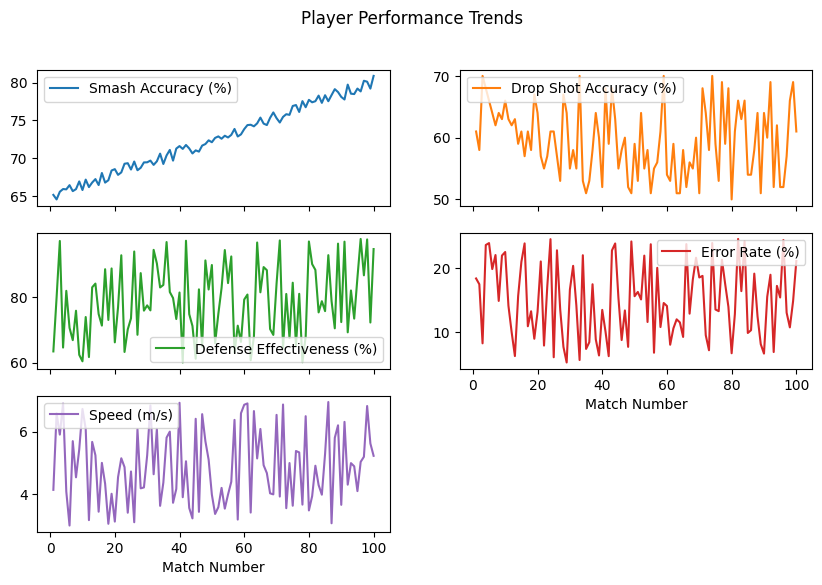

In [ ]:
player4_df.set_index('Match Number', inplace=True)

# Display first few rows
print(player4_df.head())

# Plot each feature over time
player4_df.plot(figsize=(10, 6), subplots=True, layout=(3, 2), title="Player Performance Trends")
plt.show()

In [ ]:

def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("The series is NOT stationary (Needs transformation).")
    else:
        print("The series is stationary.")

# Check stationarity for each feature
for column in player1_df.columns:
    print(f"\nChecking stationarity for: {column}")
    check_stationarity(player1_df[column])


Checking stationarity for: Match Number
ADF Statistic: -5.274998239902722
p-value: 6.16783329183601e-06
The series is stationary.

Checking stationarity for: Smash Accuracy (%)
ADF Statistic: -9.74455811789423
p-value: 8.32247140207593e-17
The series is stationary.

Checking stationarity for: Drop Shot Accuracy (%)
ADF Statistic: -9.822914446280928
p-value: 5.279610123282557e-17
The series is stationary.

Checking stationarity for: Defense Effectiveness (%)
ADF Statistic: -10.712475451545258
p-value: 3.304797156874023e-19
The series is stationary.

Checking stationarity for: Error Rate (%)
ADF Statistic: -10.157151624681042
p-value: 7.676144929532496e-18
The series is stationary.

Checking stationarity for: Speed (m/s)
ADF Statistic: -11.307764184540476
p-value: 1.2608666764264724e-20
The series is stationary.


In [ ]:
df_diff = player4_df.diff().dropna()

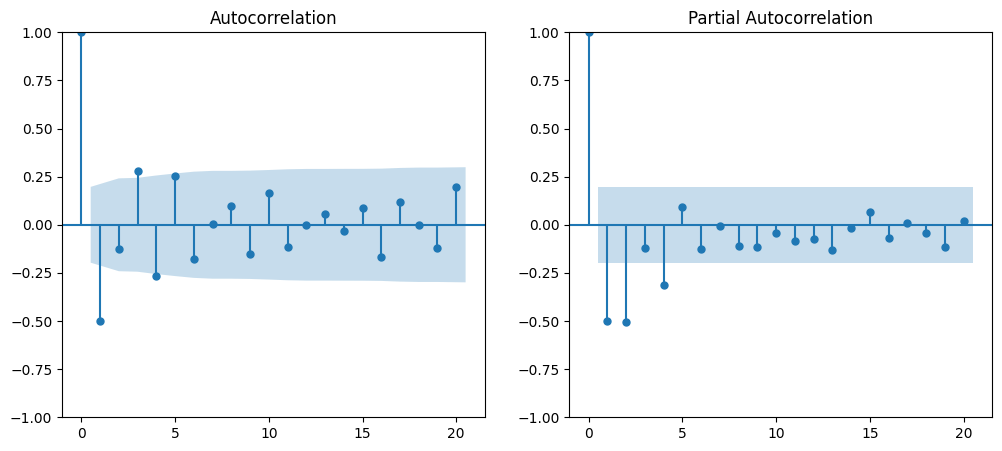

In [ ]:
feature = 'Smash Accuracy (%)'  # Choose one feature to analyze

# Plot ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df_diff[feature], ax=axes[0])   # ACF for q
plot_pacf(df_diff[feature], ax=axes[1])  # PACF for p
plt.show()

In [ ]:
SmashAccuracy = {'p': 4, 'd': 1, 'q': 2}
DropShotAccuracy = {'p': 4, 'd': 1, 'q': 2}
DefenseEffectiveness = {'p': 5, 'd': 2, 'q': 7}
ErrorRate = {'p': 5, 'd': 2, 'q': 7}
Speedms = {'p': 5, 'd': 2, 'q': 7}

# Store them in a master dictionary
metrics = {
    "SmashAccuracy": SmashAccuracy,
    "DropShotAccuracy": DropShotAccuracy,
    "DefenseEffectiveness":DefenseEffectiveness,
    "ErrorRate":ErrorRate,
    "Speedms":Speedms,
}

Model training

In [ ]:
text = "Smash Accuracy (%)"

clean_text = re.sub(r"[^a-zA-Z0-9]", "", text)

if clean_text in metrics:
    selected_dict = metrics[clean_text]
    p = selected_dict["p"]
    d = selected_dict["d"]
    q = selected_dict["q"]
    print(f"Selected Dictionary: {clean_text}")
    print(f"p: {p}, d: {d}, q: {q}")
else:
    print(f"No dictionary found for '{clean_text}'.")


data = player1_df["Smash Accuracy (%)"]



model = ARIMA(data,order=(p, d, q))
model_fit = model.fit()

# Print summary
print(model_fit.summary())

Selected Dictionary: SmashAccuracy
p: 4, d: 1, q: 2


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:     Smash Accuracy (%)   No. Observations:                  100
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -390.740
Date:                Sat, 22 Mar 2025   AIC                            795.479
Time:                        06:17:16   BIC                            813.645
Sample:                             0   HQIC                           802.829
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9581      0.115     -8.368      0.000      -1.183      -0.734
ar.L2          0.0278      0.153      0.182      0.856      -0.273       0.328
ar.L3         -0.0284      0.161     -0.176      0.8

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model evaluation


Training ARIMA for Drop Shot Accuracy (%)...
Selected Dictionary: DropShotAccuracy
p: 4, d: 1, q: 2


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                  
Dep. Variable:     Drop Shot Accuracy (%)   No. Observations:                  100
Model:                     ARIMA(4, 1, 2)   Log Likelihood                -312.080
Date:                    Sat, 22 Mar 2025   AIC                            638.159
Time:                            06:21:03   BIC                            656.325
Sample:                                 0   HQIC                           645.509
                                    - 100                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5132      1.451     -0.354      0.724      -3.358       2.331
ar.L2         -0.0264      0.171     -0.154      0.877      -0.361       0.308
ar.L3         -0.114

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


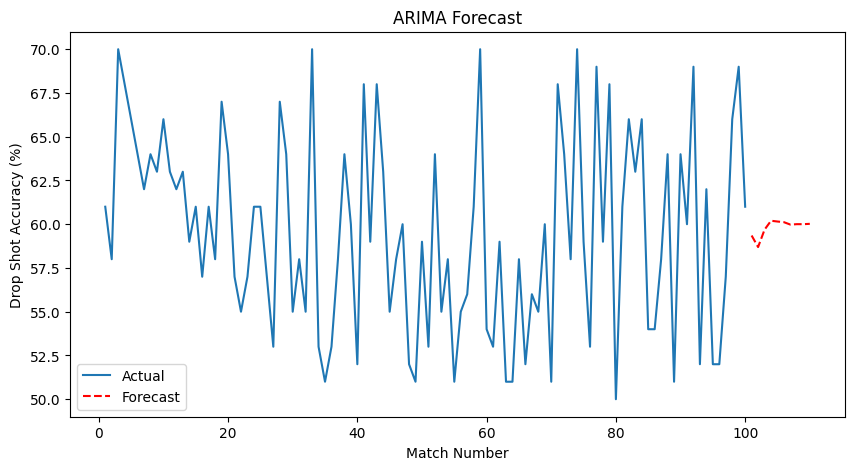

In [ ]:
feature = "Drop Shot Accuracy (%)"

print(f"\nTraining ARIMA for {feature}...")

clean_text = re.sub(r"[^a-zA-Z0-9]", "", feature)

if clean_text in metrics:
  selected_dict = metrics[clean_text]
  p = selected_dict["p"]
  d = selected_dict["d"]
  q = selected_dict["q"]
  print(f"Selected Dictionary: {clean_text}")
  print(f"p: {p}, d: {d}, q: {q}")
else:
  print(f"No dictionary found for '{clean_text}'.")



model = ARIMA(player4_df[feature], order=(p, d, q))
model_fit = model.fit()

# Print summary
print(model_fit.summary())

forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

# Plot actual vs forecasted values
plt.figure(figsize=(10, 5))
plt.plot(player4_df.index, player4_df[feature], label='Actual')
plt.plot(range(player4_df.index[-1] + 1, player4_df.index[-1] + 1 + forecast_steps), forecast, label='Forecast', linestyle='dashed', color='red')
plt.xlabel("Match Number")
plt.ylabel(feature)
plt.title("ARIMA Forecast")
plt.legend()
plt.show()


Training ARIMA for Smash Accuracy (%)...
Selected Dictionary: SmashAccuracy
p: 4, d: 1, q: 2


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

                               SARIMAX Results                                
Dep. Variable:     Smash Accuracy (%)   No. Observations:                  100
Model:                 ARIMA(4, 1, 2)   Log Likelihood                 -85.737
Date:                Sat, 22 Mar 2025   AIC                            185.474
Time:                        06:12:04   BIC                            203.640
Sample:                             0   HQIC                           192.824
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6665      0.106     -6.300      0.000      -0.874      -0.459
ar.L2          0.4812      0.105      4.584      0.000       0.275       0.687
ar.L3          0.7676      0.092      8.339      0.0

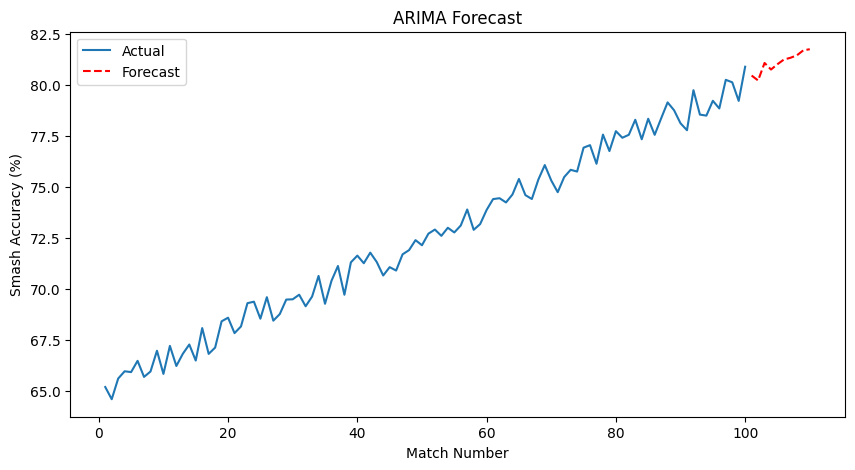


Training ARIMA for Drop Shot Accuracy (%)...
Selected Dictionary: DropShotAccuracy
p: 4, d: 1, q: 2


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                  
Dep. Variable:     Drop Shot Accuracy (%)   No. Observations:                  100
Model:                     ARIMA(4, 1, 2)   Log Likelihood                -312.080
Date:                    Sat, 22 Mar 2025   AIC                            638.159
Time:                            06:12:05   BIC                            656.325
Sample:                                 0   HQIC                           645.509
                                    - 100                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5132      1.451     -0.354      0.724      -3.358       2.331
ar.L2         -0.0264      0.171     -0.154      0.877      -0.361       0.308
ar.L3         -0.114

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


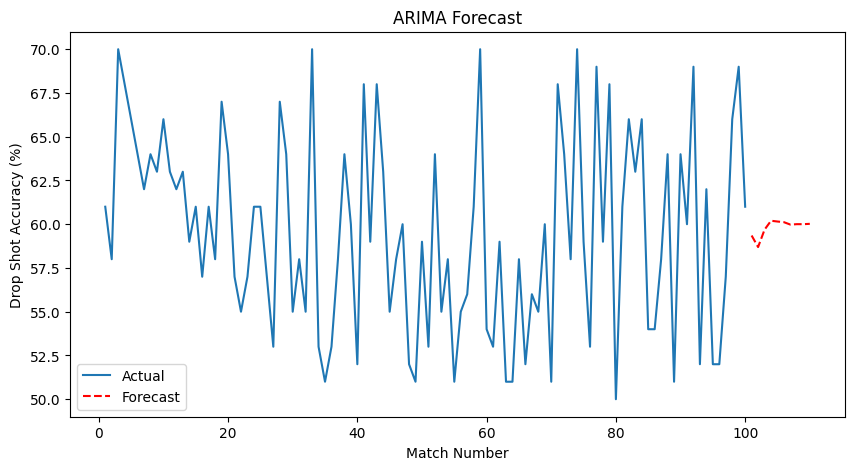


Training ARIMA for Defense Effectiveness (%)...
Selected Dictionary: DefenseEffectiveness
p: 5, d: 2, q: 7


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

                                   SARIMAX Results                                   
Dep. Variable:     Defense Effectiveness (%)   No. Observations:                  100
Model:                        ARIMA(5, 2, 7)   Log Likelihood                -369.293
Date:                       Sat, 22 Mar 2025   AIC                            764.586
Time:                               06:12:06   BIC                            798.190
Sample:                                    0   HQIC                           778.178
                                       - 100                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2741      1.066     -1.195      0.232      -3.363       0.815
ar.L2         -1.0633      1.465     -0.726      0.468      -3.934       1.

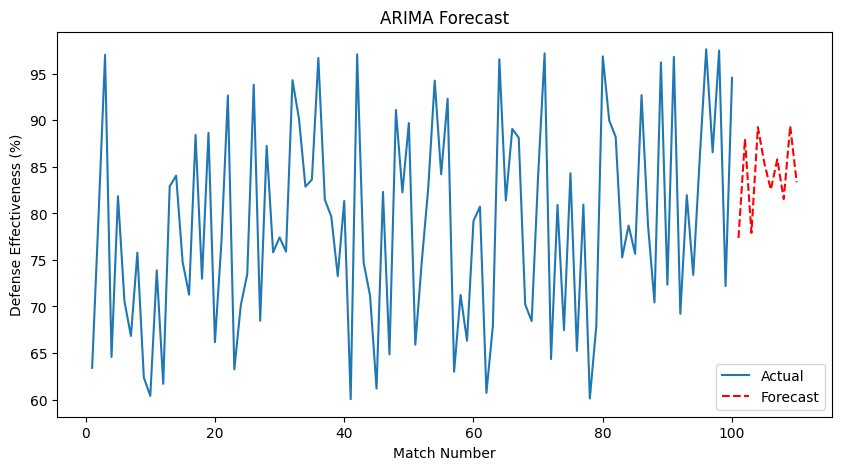


Training ARIMA for Error Rate (%)...
Selected Dictionary: ErrorRate
p: 5, d: 2, q: 7


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

                               SARIMAX Results                                
Dep. Variable:         Error Rate (%)   No. Observations:                  100
Model:                 ARIMA(5, 2, 7)   Log Likelihood                -315.611
Date:                Sat, 22 Mar 2025   AIC                            657.221
Time:                        06:12:07   BIC                            690.826
Sample:                             0   HQIC                           670.814
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9231      1.014     -1.897      0.058      -3.910       0.064
ar.L2         -2.2526      1.767     -1.275      0.202      -5.715       1.210
ar.L3         -2.0143      1.944     -1.036      0.3

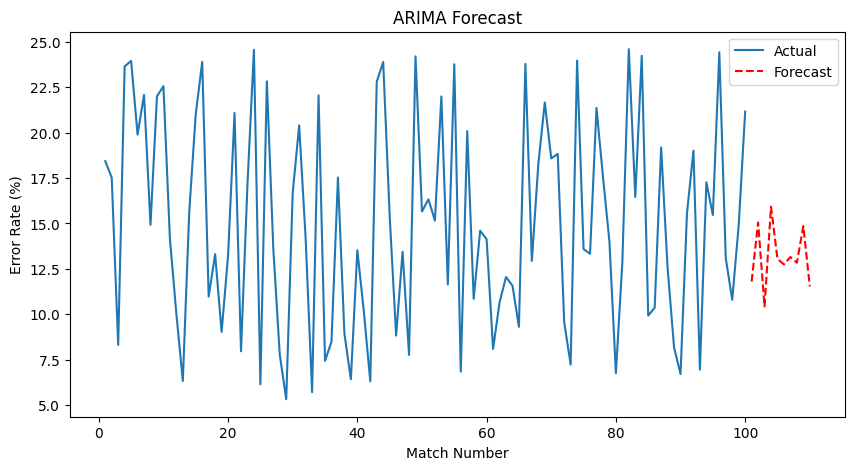


Training ARIMA for Speed (m/s)...
Selected Dictionary: Speedms
p: 5, d: 2, q: 7


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as s

                               SARIMAX Results                                
Dep. Variable:            Speed (m/s)   No. Observations:                  100
Model:                 ARIMA(5, 2, 7)   Log Likelihood                -157.174
Date:                Sat, 22 Mar 2025   AIC                            340.347
Time:                        06:12:08   BIC                            373.952
Sample:                             0   HQIC                           353.940
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.8749      1.307     -2.200      0.028      -5.436      -0.313
ar.L2         -4.3277      2.603     -1.662      0.096      -9.430       0.775
ar.L3         -4.0182      3.374     -1.191      0.2

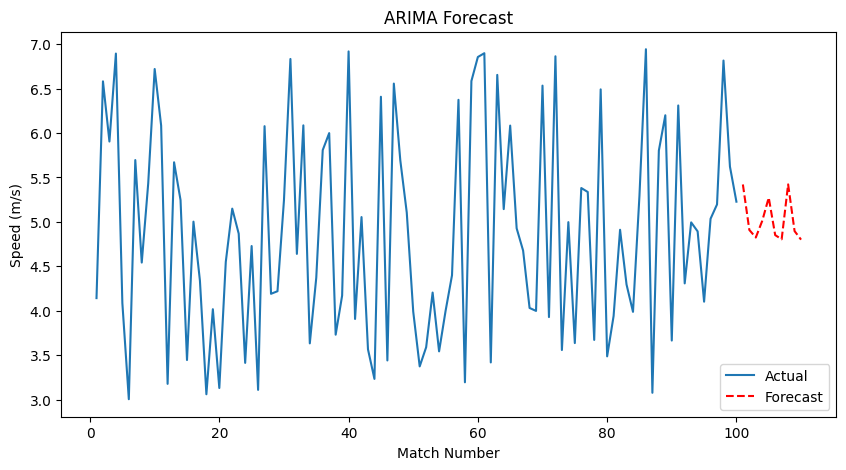

In [ ]:
for feature in player4_df.columns:
    print(f"\nTraining ARIMA for {feature}...")

    clean_text = re.sub(r"[^a-zA-Z0-9]", "", feature)

    if clean_text in metrics:
      selected_dict = metrics[clean_text]
      p = selected_dict["p"]
      d = selected_dict["d"]
      q = selected_dict["q"]
      print(f"Selected Dictionary: {clean_text}")
      print(f"p: {p}, d: {d}, q: {q}")
    else:
      print(f"No dictionary found for '{clean_text}'.")



    model = ARIMA(player4_df[feature], order=(p, d, q))
    model_fit = model.fit()

    # Print summary
    print(model_fit.summary())

    forecast_steps = 10
    forecast = model_fit.forecast(steps=forecast_steps)

    # Plot actual vs forecasted values
    plt.figure(figsize=(10, 5))
    plt.plot(player4_df.index, player4_df[feature], label='Actual')
    plt.plot(range(player4_df.index[-1] + 1, player4_df.index[-1] + 1 + forecast_steps), forecast, label='Forecast', linestyle='dashed', color='red')
    plt.xlabel("Match Number")
    plt.ylabel(feature)
    plt.title("ARIMA Forecast")
    plt.legend()
    plt.show()